In [2]:
%load_ext autoreload
%autoreload 2 
# !apt-get install -y xvfb
import time
import torch
from collections import Counter
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
# https://www.youtube.com/watch?v=QLIkOtKS4os --> creating custom dataset in pytorch geometric
from torch.utils.data import Dataset, random_split
import torch_geometric
from torch_geometric.data import Data, InMemoryDataset
import torch_geometric
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import pickle
import random
import os

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.preprocessing import LabelEncoder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Utility Functions

In [3]:


def set_device_and_seed(GPU=True, seed=0, gpu_name = "cuda:0"):
    torch.cuda.is_available()
    if GPU:
        device = torch.device(gpu_name if torch.cuda.is_available() else 'cpu')
    else:
        device = torch.device("cpu")
    print(f'Using {device}')

    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed(seed)

        
    set_seed(seed)
    
    return device

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    print(f"Setting torch, cuda, numpy and random seeds to {seed}")


def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

    
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [4]:
# Setting random seed and device
GPU = True # Choose whether to use GPU
device =set_device_and_seed(GPU=False, seed=0, gpu_name='cuda:0')

Using cpu
Setting torch, cuda, numpy and random seeds to 0


### Load Data


In [9]:
orig_df = pd.read_csv(os.path.abspath("/home/sneha/e5_cleaned_normalised.csv"))
orig_df.describe()

,idno,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,dircosy,...,sublobe_norm,x_norm,y_norm,z_norm,parent_loc_x_norm,parent_loc_y_norm,parent_loc_z_norm,dircosx_norm,dircosy_norm,dircosz_norm
count,1.923480e+05,192348.000000,192348.000000,192348.000000,192348.000000,192348.000000,192348.000000,192348.000000,192348.000000,192348.000000,...,192348.000000,192348.000000,192348.000000,192348.000000,192348.000000,192348.000000,192348.000000,192348.000000,192348.000000,192348.000000
mean,5.468308e+06,14.054362,30.922819,2.687457,7.267437,91.770161,62.903961,145.613876,-0.063054,0.058984,...,0.382497,0.514556,0.557489,0.457754,0.467074,0.459076,0.491710,0.468473,0.529492,0.579373
std,1.750314e+06,13.617144,45.691963,1.633118,6.673135,93.405512,78.044675,25.089683,0.496838,0.481001,...,0.351218,0.202735,0.092820,0.137163,0.202791,0.109102,0.141752,0.248419,0.240500,0.349693
min,3.010007e+06,0.500000,-1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,-1.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.014707e+06,7.987815,7.956605,1.000000,0.000000,23.000000,11.000000,137.847000,-0.462468,-0.312348,...,0.000000,0.341036,0.498595,0.343589,0.288945,0.388047,0.388594,0.268766,0.343826,0.225924
50%,5.021758e+06,11.267850,16.114850,3.000000,9.000000,60.000000,33.000000,151.227000,-0.059549,0.099504,...,0.473684,0.407190,0.554323,0.464765,0.369258,0.455009,0.497080,0.470225,0.549752,0.693828
75%,7.016395e+06,15.571700,33.490475,4.000000,13.000000,132.000000,86.000000,160.265000,0.343982,0.408248,...,0.684211,0.729171,0.614242,0.560139,0.687667,0.526611,0.591823,0.671991,0.704124,0.904145
max,8.024995e+06,149.707000,2585.770000,5.000000,19.000000,1059.000000,1028.000000,180.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
label_df = pd.read_csv(os.path.abspath("/home/sneha/MESA_Exam5_airway_variants.csv"))

####  Class distribution of the labels 

In [11]:
pilot_df_w_labels = orig_df.merge(label_df, on='idno', how='left')
# drop nan labels
print(len(pilot_df_w_labels), pilot_df_w_labels.idno.nunique())
pilot_df_w_labels.dropna(subset='LL_1', inplace=True)

print(len(pilot_df_w_labels), pilot_df_w_labels.idno.nunique())

192348 2909
191383 2890


In [12]:
print("Label frequency distribution")
label_freq = pilot_df_w_labels.groupby('LL_1').agg({'idno':lambda x:x.nunique()})
total = label_freq.idno.sum()
label_freq['percent'] = label_freq.idno.apply(lambda x:np.round(100*x/total, 2))
label_freq.rename({'idno':'#participants'}, inplace=True)
label_freq

Label frequency distribution


,idno,percent
LL_1,,
Abs. RB7,163,5.64
Acc. B*,412,14.26
Acc. LB7,42,1.45
Standard,2101,72.70
Unclass.,172,5.95


In [14]:
# drop unclassified from training data
pilot_df_w_labels = pilot_df_w_labels.loc[~(pilot_df_w_labels.LL_1.str.lower().str.contains('unclass'))]


In [15]:
# make labels binary
binary_label = {
    
    'Abs. RB7': 1,
'Acc. B*': 1,
'Acc. LB7':1,
'Standard':0
    
    
}
pilot_df_w_labels['binaryLL_1'] = pilot_df_w_labels.LL_1.apply(lambda x: binary_label[x])

binary_label_freq = pilot_df_w_labels.groupby('binaryLL_1').agg({'idno':lambda x:x.nunique()})
total = binary_label_freq.idno.sum()
binary_label_freq['percent'] = binary_label_freq.idno.apply(lambda x:np.round(100*x/total, 2))
binary_label_freq.rename({'idno':'#participants'}, inplace=True)
binary_label_freq

,idno,percent
binaryLL_1,,
0,2101,77.3
1,617,22.7


In [16]:
pilot_df_w_labels.columns

Index(['idno', 'anatomicalname', 'centerlinelength', 'avginnerarea', 'lobe',
       'sublobe', 'endbpid', 'startbpid', 'angle', 'dircosx', 'dircosy',
       'dircosz', 'weibel_generation', 'QC', 'x', 'y', 'z', 'parent_loc_x',
       'parent_loc_y', 'parent_loc_z', 'endbpid_nn_in_lobe', 'dist_nn_in_lobe',
       'num_desc', 'max_path_length', 'centerlinelength_norm',
       'avginnerarea_norm', 'dist_nn_in_lobe_norm', 'max_path_length_norm',
       'angle_norm', 'weibel_generation_norm', 'num_desc_norm', 'lobe_norm',
       'sublobe_norm', 'x_norm', 'y_norm', 'z_norm', 'parent_loc_x_norm',
       'parent_loc_y_norm', 'parent_loc_z_norm', 'dircosx_norm',
       'dircosy_norm', 'dircosz_norm', 'LL_1', 'Standard', 'Acc_B', 'Abs_RB7',
       'Acc_LB7', 'Rare', 'Unclassified', 'binaryLL_1'],
      dtype='object')

In [64]:
# drop irrellevant cols
pilot_df = pilot_df_w_labels.copy()
binary_label_df = pilot_df[['idno', 'binaryLL_1']]

In [65]:
# SAVE PILOT DF for training
pilot_df.to_csv('/home/sneha/e5_cleaned_normalised_w_labels.csv')
binary_label_df.to_csv('/home/sneha/e5_binary_labels.csv')

## Make a graph sample & visualise in networkx

/tmp/ipykernel_28426/640908086.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_w_coords['anatomicalname'] = tree_w_coords['anatomicalname'].apply(lambda x:"" if ('unnamed' in x) or (x == '-') else x)


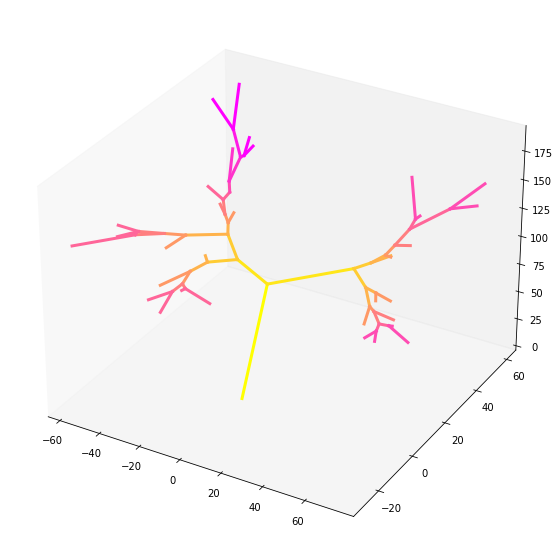

In [24]:
tree_w_coords = pilot_df[(pilot_df.idno ==3011950)]
val_min = tree_w_coords.weibel_generation.min()
val_max=tree_w_coords.weibel_generation.max()
# cmap = mpl.cm.RdYlGn#.reversed()
cmap = mpl.colormaps['spring'].reversed()
norm = mpl.colors.Normalize(vmin=val_min, vmax=val_max)


# simpliofy names
tree_w_coords['anatomicalname'] = tree_w_coords['anatomicalname'].apply(lambda x:"" if ('unnamed' in x) or (x == '-') else x)

row = tree_w_coords.iloc[0]
# quick visualisation of tree

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for i in range(len(tree_w_coords)):
    row = tree_w_coords.iloc[i]
    ax.plot([row.parent_loc_x,row.x], [row.parent_loc_y,row.y], [row.parent_loc_z, row.z], linestyle='-',linewidth=3, color= cmap(norm(row.weibel_generation)), label=row.anatomicalname)
ax.grid(False)
ax.set_facecolor(color=(1,1,1))
plt.show()

In [29]:
tree_w_coords.columns

Index(['idno', 'anatomicalname', 'centerlinelength', 'avginnerarea', 'lobe',
       'sublobe', 'endbpid', 'startbpid', 'angle', 'dircosx', 'dircosy',
       'dircosz', 'weibel_generation', 'QC', 'x', 'y', 'z', 'parent_loc_x',
       'parent_loc_y', 'parent_loc_z', 'endbpid_nn_in_lobe', 'dist_nn_in_lobe',
       'num_desc', 'max_path_length', 'centerlinelength_norm',
       'avginnerarea_norm', 'dist_nn_in_lobe_norm', 'max_path_length_norm',
       'angle_norm', 'weibel_generation_norm', 'num_desc_norm', 'lobe_norm',
       'sublobe_norm', 'x_norm', 'y_norm', 'z_norm', 'parent_loc_x_norm',
       'parent_loc_y_norm', 'parent_loc_z_norm', 'dircosx_norm',
       'dircosy_norm', 'dircosz_norm', 'LL_1', 'Standard', 'Acc_B', 'Abs_RB7',
       'Acc_LB7', 'Rare', 'Unclassified', 'binaryLL_1'],
      dtype='object')

In [30]:
tree_w_coords.head()[[ 'x', 'y', 'z', 'parent_loc_x',
       'parent_loc_y', 'parent_loc_z','x_norm', 'y_norm', 'z_norm', 'parent_loc_x_norm',
       'parent_loc_y_norm', 'parent_loc_z_norm']]

,x,y,z,parent_loc_x,parent_loc_y,parent_loc_z,x_norm,y_norm,z_norm,parent_loc_x_norm,parent_loc_y_norm,parent_loc_z_norm
5459,-1.065691,15.985358,80.459797,0.000000,0.000000,0.000000,0.522398,0.487989,0.255950,0.478133,0.278739,0.000000
5460,-12.858437,12.616001,100.675958,-1.065691,15.985358,80.459797,0.469716,0.473892,0.322418,0.472851,0.369629,0.287465
5461,38.909595,18.483814,111.690518,-1.065691,15.985358,80.459797,0.700983,0.498442,0.358632,0.472851,0.369629,0.287465
5462,-18.010936,13.131251,119.740224,-12.858437,12.616001,100.675958,0.446697,0.476047,0.385098,0.414404,0.350471,0.359693
5463,-25.499410,9.954747,95.353449,-12.858437,12.616001,100.675958,0.413244,0.462757,0.304918,0.414404,0.350471,0.359693


In [55]:
# nodes and features (pos, direction,lobe + sublobe categorical, angle to parent, weibel gen, dist to nearest neighbor in lobe, max path length to leaf, num descendents of node)
node_features = ['x_norm', 'y_norm', 'z_norm', 'dircosx_norm',
       'dircosy_norm', 'dircosz_norm','lobe_norm',
       'sublobe_norm','angle_norm', 'weibel_generation_norm','dist_nn_in_lobe_norm', 'num_desc_norm','max_path_length_norm']

nodes = list(zip(tree_w_coords.endbpid, tree_w_coords[node_features].to_dict(orient='records')))
trachea_dict = dict.fromkeys(node_features, 0)
for i in ['x_norm', 'y_norm', 'z_norm']:
    trachea_dict[i] = tree_w_coords.loc[tree_w_coords.startbpid==-1][str('parent_loc_'+i)].item()
nodes =[(-1, trachea_dict)]+nodes
# nodes
list(trachea_dict.values())

list_of_nodes = tree_w_coords[node_features].to_dict(orient='records')
list_of_lists_nodes =[list(trachea_dict.values())]+ [list(node_feature.values()) for node_feature in list_of_nodes]
len(list_of_lists_nodes), len(nodes)
x = torch.tensor(list_of_lists_nodes, dtype=torch.float)

In [60]:
print(tree_w_coords.reset_index().endbpid.to_dict())
relabel_map = {v:k+1 for k,v in tree_w_coords.reset_index().endbpid.to_dict().items()}
relabel_map
# x_list_plus_trachea = [[0,0,0,-1]]+ df_w_coords.apply(lambda row:row[['x','y','z', 'weibel_generation']].to_list(), axis=1).to_list() # here only node features are pos and weibel gen
# x = torch.tensor(x_list_plus_trachea, dtype=torch.float)

{0: 1.0, 1: 6.0, 2: 7.0, 3: 19.0, 4: 18.0, 5: 11.0, 6: 10.0, 7: 15.0, 8: 14.0, 9: 17.0, 10: 16.0, 11: 22.0, 12: 23.0, 13: 25.0, 14: 24.0, 15: 26.0, 16: 27.0, 17: 28.0, 18: 29.0, 19: 30.0, 20: 31.0, 21: 37.0, 22: 36.0, 23: 45.0, 24: 44.0, 25: 49.0, 26: 48.0, 27: 53.0, 28: 52.0, 29: 54.0, 30: 55.0, 31: 62.0, 32: 63.0, 33: 74.0, 34: 75.0, 35: 81.0, 36: 80.0, 37: 91.0, 38: 90.0, 39: 95.0, 40: 94.0, 41: 103.0, 42: 102.0, 43: 104.0, 44: 105.0, 45: 111.0, 46: 110.0, 47: 112.0, 48: 113.0, 49: 120.0, 50: 121.0, 51: 123.0, 52: 122.0, 53: 141.0, 54: 140.0, 55: 142.0, 56: 143.0, 57: 151.0, 58: 150.0, 59: 206.0, 60: 245.0, 61: 246.0, 62: 267.0, 63: 268.0, 64: 282.0, 65: 281.0, 66: 283.0, 67: 284.0}


{1.0: 1,
 6.0: 2,
 7.0: 3,
 19.0: 4,
 18.0: 5,
 11.0: 6,
 10.0: 7,
 15.0: 8,
 14.0: 9,
 17.0: 10,
 16.0: 11,
 22.0: 12,
 23.0: 13,
 25.0: 14,
 24.0: 15,
 26.0: 16,
 27.0: 17,
 28.0: 18,
 29.0: 19,
 30.0: 20,
 31.0: 21,
 37.0: 22,
 36.0: 23,
 45.0: 24,
 44.0: 25,
 49.0: 26,
 48.0: 27,
 53.0: 28,
 52.0: 29,
 54.0: 30,
 55.0: 31,
 62.0: 32,
 63.0: 33,
 74.0: 34,
 75.0: 35,
 81.0: 36,
 80.0: 37,
 91.0: 38,
 90.0: 39,
 95.0: 40,
 94.0: 41,
 103.0: 42,
 102.0: 43,
 104.0: 44,
 105.0: 45,
 111.0: 46,
 110.0: 47,
 112.0: 48,
 113.0: 49,
 120.0: 50,
 121.0: 51,
 123.0: 52,
 122.0: 53,
 141.0: 54,
 140.0: 55,
 142.0: 56,
 143.0: 57,
 151.0: 58,
 150.0: 59,
 206.0: 60,
 245.0: 61,
 246.0: 62,
 267.0: 63,
 268.0: 64,
 282.0: 65,
 281.0: 66,
 283.0: 67,
 284.0: 68}

In [32]:
# edges and features: TODO include all features relevant + NORMALISE
edge_features = ['centerlinelength_norm',
       'avginnerarea_norm']

edges = list(zip(tree_w_coords.startbpid, tree_w_coords.endbpid))
edges_with_features = dict(zip(edges,tree_w_coords[edge_features].to_dict(orient='records')))


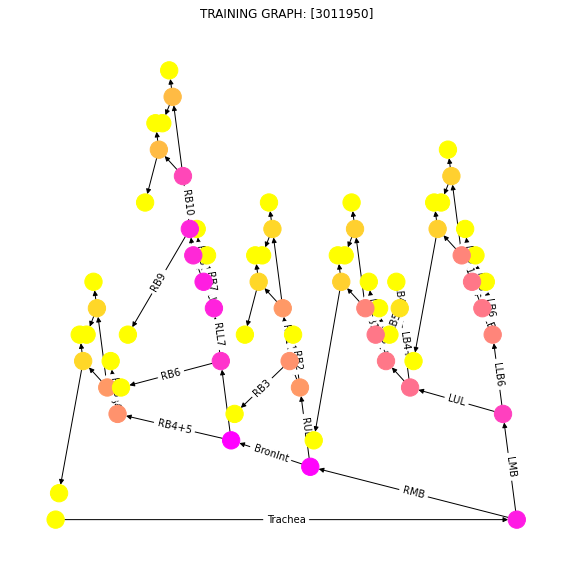

In [35]:


g = nx.DiGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

nx.set_edge_attributes(g,edges_with_features)
# print(g.edges(data=True))
# print(g.nodes(data=True))
# 2D projection of tree (excluding the trachea itself)
col = nx.betweenness_centrality(g)

val_min = min(col.values())
val_max=max(col.values())
# cmap = mpl.cm.RdYlGn#.reversed()
cmap = mpl.colormaps['spring'].reversed()
norm = mpl.colors.Normalize(vmin=val_min, vmax=val_max)
cmap_nodes = [cmap(norm(col[node])) for node in g.nodes()]

# cmap_nodes = [cmap(norm(g.nodes[node]['weibel_generation']))for node in g.nodes() if not len(g.nodes[node])==0]
# labels = {node:g.nodes[node]['anatomicalname'] for node in g.nodes() if (not len(g.nodes[node])==0) & (len(g.nodes[node]['anatomicalname']) > 1)}
edge_labels = {edge:tree_w_coords.loc[tree_w_coords.endbpid == edge[1]]['anatomicalname'].item() for edge in g.edges() }
# print('edge', edge_labels)
pos = nx.planar_layout(g, scale=1, center=(0,0), dim=2)

f, ax = plt.subplots(figsize=(10,10))
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
nx.draw(g,pos=pos, with_labels=False,node_color=cmap_nodes, ax=ax)
nx.draw_networkx_edge_labels(g, pos,
                          edge_labels,
                             font_color='k',
                             font_size='10',
                          label_pos=0.5,
                          )
plt.title(f'TRAINING GRAPH: {tree_w_coords.idno.unique()}')
# plt.colorbar(cmap_nodes, cax=cax, orientation='vertical')
plt.show()

## Pytorch Dataset for Geometric

- TODO drop the unclassified examples
- MAKE BINARY LABELS
- WEIGHTED LOSS
- SPLIT TRAIN TEST
- LOOK INTO BETTER GCNS
- FEATURE ENGINEERING AND NORMALISATION

In [37]:

# g = torch_geometric.utils.to_networkx(# torch dataset, to_undirected=False)
# nx.draw_planar(g, with_labels=True)
# g.edges()

# WHAT IS RAW PATHS

In [36]:
class CustomDataset(torch_geometric.data.Dataset):
    def __init__(self,root, filename_data, filename_labels, test=False, transform=None, pre_transform=None):
        '''
        root = where dataset should be stored, folder is split into raw_dir and processed_dir
        filename_data = contains X features for nodes + edges (csv)
        filename_labels= contains Y labels for graphs (csv)
        '''
        # super(CustomDataset, self).__init__(root, transform, pre_transform)
        self.test = test
        self.filename_data = filename_data
        self.filename_labels = filename_labels
        super(CustomDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        return self.filename_data
    
    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
    
    def _download(self):
        pass
    
    def process(self):
        self.data = pd.read_csv(os.path.abspath(self.raw_paths[0]))
        label_df = self._process_labels()
        graph_ids = self.data.idno.unique()
        
        for i, idno in tqdm(list(enumerate(graph_ids))):
            # iterate through each patricipant (resetindex is important for node relabelling)
            df = self.data.loc[self.data.idno == idno].copy().reset_index()
            # build a graph out of the df with node features, edge_features and edge_adjacency
            x = self._get_node_features(df)
            edge_adjacency = self._get_edge_adjacency(df)
            edge_features = self._get_edge_features(df)
            y = self._get_label(idno, label_df)
            data = Data(x=x,
                        edge_index=edge_adjacency,
                        edge_attr = edge_features,
                        y = y
                       )
            if self.test:
                torch.save(data, 
                            os.path.join(self.processed_dir, 
                                         f'data_test_{i}.pt'))
            else:
                 torch.save(data, 
                            os.path.join(self.processed_dir, 
                                         f'data_{i}.pt'))
    
    
    def _process_labels(self):
        '''
        Reads label df - checks its binary 0,1 labels (REQUIRES COLUMN binaryLL_1) if not returns an error 
        Keeps only rows that match idnos in self.data_df which is processed first
        measures class proportions and saves to self.class_proportions
        returns a df which has a label per idno with label in col called 'y'
        '''
        #(NOTE THIS IS WRONG YOU NEED TO DROP UNALBELLED)
        label_df = pd.read_csv(os.path.abspath(self.filename_labels))
        # binarise 
        assert 'binaryLL_1' in label_df.columns, "The column binaryLL_1 cannot be found"
        # drop unnecessary cols
        
        # drop rows not matching to data ids
        data_df =  pd.read_csv(os.path.abspath(self.filename_data))
        label_df_small = label_df.loc[label_df.idno.isin(data_df.idno.unique())]
        
        print("# Graphs", len(label_df_small), "Label Frequency", Counter(label_df_small['binaryLL_1'].to_list()))
        self.class_proportions = {k:v/len(label_df_small) for k,v in Counter(label_df_small['binaryLL_1'].to_list()).items()}
        print(f"Class proportions: {self.class_proportions}")
        return label_df_small
    
    def _get_edge_adjacency(self,df):
        '''
        NOTE pytorch requires nodes to start from 0 and go up in integers so need to remap start and end bpids from df
        Turns endbpid 1 > 1, if the next one in the df is endbpid=6 it becomes 2 etc so that the endbpids are in order from 1 to max (index+1)
        Adds trachea (node 0)
        applyys relabelling to start and endbpid based on the dict 
        returns torch tensor in COO format which is a parallel list [[source_node_list], [corresponding_end_node_list]]
        in this format, at list[0][2] and list[1][2] will be source-end node of the second edge in the list
        '''
        # reindex start / endbpids
        relabel_map = {v:k+1 for k,v in df.endbpid.to_dict().items()}
        # add trachea map (node 0)
        relabel_map[-1] = 0
        # apply relabelling to source and end nodes
        source_nodes = df.startbpid.apply(lambda x: relabel_map[x]).to_list()
        end_nodes = df.endbpid.apply(lambda x: relabel_map[x]).to_list()
        # return in COO format
        return torch.tensor([source_nodes, end_nodes], dtype=torch.long)

    def _get_node_features(self,df):
        '''
        DF already contains normalised features
        Feature names in node_features
        Format to return is a tensor of shape num_nodes x node_feature_dim with dtype float 
        assumes ordered in ascending order with nodes 0 and up in integers (so node = index / row num)
        '''
        # nodes and features (pos, direction,lobe + sublobe categorical, angle to parent, weibel gen, dist to nearest neighbor in lobe, max path length to leaf, num descendents of node)
        node_features = ['x_norm', 'y_norm', 'z_norm', 'dircosx_norm',
               'dircosy_norm', 'dircosz_norm','lobe_norm',
               'sublobe_norm','angle_norm', 'weibel_generation_norm','dist_nn_in_lobe_norm', 'num_desc_norm','max_path_length_norm']
        # adding trachea info to top of list
        trachea_dict = dict.fromkeys(node_features, 0)
        for i in ['x_norm', 'y_norm', 'z_norm']:
            trachea_dict[i] = tree_w_coords.loc[tree_w_coords.startbpid==-1][str('parent_loc_'+i)].item()
        
        # currently usnig as features 
        list_of_nodes = df[node_features].to_dict(orient='records')
        # add trachea to nodes
        list_of_lists_nodes =[list(trachea_dict.values())]+ [list(node_feature.values()) for node_feature in list_of_nodes]
        x = torch.tensor(list_of_lists_nodes, dtype=torch.float)
        print("Shape node features", x.shape)
        return x

    def _get_edge_features(self,df):
        '''
        get matrix of shape [# edges, edge feature size] with type float
        '''
        edge_feature_names = ['centerlinelength_norm','avginnerarea_norm']
        edge_norm = df[edge_feature_names].values
        return torch.tensor(edge_norm, dtype=torch.float)

    def _get_label(self, idno, label_df):
        '''
        for the selected idno, returns value in binaryLL_1 col as an integer
        '''
        return torch.tensor(label_df.loc[label_df.idno==idno,
                 'binaryLL_1'].values, dtype=torch.int64)
    
    def len(self):
        return int(self.data.idno.nunique())
    
    def get(self, idx):
        '''
        Equivalent to __getitem__ in pytorch
        '''
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))   
        return data
            

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)


my_data  = CustomDataset('data/', '/home/sneha/e5_cleaned_normalised_w_labels.csv',"/home/sneha/e5_binary_labels.csv")


Processing...


# Graphs 227 Label Frequency Counter({1: 177, 0: 50})
{1: 0.7797356828193832, 0: 0.22026431718061673}


  0%|                                                                                           | 0/227 [00:00<?, ?it/s]


NameError: name '_get_coords' is not defined

In [56]:
train_loader = DataLoader(my_data, batch_size=16, shuffle=True)
print(train_loader.dataset.class_proportions)

{1: 0.7797356828193832, 0: 0.22026431718061673}


In [19]:
m = nn.Softmax()
input = torch.randn(2, 3)
print(input)
print(m(input))
m(input).argmax(dim=1)

tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986]])
tensor([[0.8446, 0.1349, 0.0205],
        [0.7511, 0.1438, 0.1051]])


/tmp/ipykernel_9786/4204858206.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(m(input))
/tmp/ipykernel_9786/4204858206.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  m(input).argmax(dim=1)


tensor([0, 0])

### MODELS

In [ ]:

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        
        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
                
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)
    
    
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

model = GAT().to(device)
data = dataset[0].to(device)
print(data)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    print(out.shape)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    if epoch%200 == 0:
        print(loss)
    
    loss.backward()
    optimizer.step()
    
    

In [31]:


class GCN(torch.nn.Module):
    def __init__(self,in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return torch.tensor(x)

def _count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad == True)
    
model = GCN(in_channels=4, hidden_channels=8, out_channels=1)
print(model)
print(list(model.parameters()))

GCN(
  (conv1): GCNConv(4, 8)
  (conv2): GCNConv(8, 8)
  (conv3): GCNConv(8, 8)
  (lin): Linear(in_features=8, out_features=1, bias=True)
)
[Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[-0.2659, -0.1007, -0.3153, -0.0881],
        [ 0.6361, -0.6798, -0.3345,  0.6009],
        [-0.0372, -0.1469,  0.2378, -0.2987],
        [ 0.2904, -0.4362, -0.2126,  0.5412],
        [ 0.0693, -0.5593,  0.4248, -0.4699],
        [-0.0456, -0.0020, -0.3116,  0.3165],
        [-0.0699,  0.3861,  0.3593, -0.5530],
        [ 0.5281,  0.0176,  0.5583,  0.4401]], requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[-0.3485,  0.2862, -0.5823, -0.2902,  0.2441,  0.5731,  0.3985,  0.2532],
        [-0.4325,  0.1859, -0.2230,  0.0355, -0.0784,  0.5731,  0.3995,  0.0641],
        [-0.5954,  0.4798,  0.4201,  0.2081, -0.6052, -0.4069,  0.3224, -0.5745],
        [ 0

In [21]:
loss = nn.CrossEntropyLoss()
input_ = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
print(input)
print(target)
loss(input_, target)

tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986]])
tensor([0, 3, 2])


tensor(2.7728, grad_fn=<NllLossBackward0>)

Using cpu
Setting torch, cuda, numpy and random seeds to 0
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_9786/2828724317.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.55it/s]


Epoch: 0, Loss: 1.39


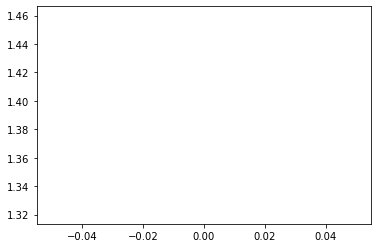

Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_9786/2828724317.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.83it/s]


Epoch: 1, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.30it/s]


Epoch: 2, Loss: 1.42
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.85it/s]


Epoch: 3, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.36it/s]


Epoch: 4, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.19it/s]


Epoch: 5, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.15it/s]


Epoch: 6, Loss: 1.44
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.12it/s]


Epoch: 7, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.73it/s]


Epoch: 8, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.21it/s]


Epoch: 9, Loss: 1.39
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.33it/s]


Epoch: 10, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.25it/s]


Epoch: 11, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.45it/s]


Epoch: 12, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.62it/s]


Epoch: 13, Loss: 1.45
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.40it/s]


Epoch: 14, Loss: 1.42
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.73it/s]


Epoch: 15, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.09it/s]


Epoch: 16, Loss: 1.45
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.29it/s]


Epoch: 17, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.93it/s]


Epoch: 18, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.17it/s]


Epoch: 19, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.03it/s]


Epoch: 20, Loss: 1.39
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.23it/s]


Epoch: 21, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.15it/s]


Epoch: 22, Loss: 1.39
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.71it/s]


Epoch: 23, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.86it/s]


Epoch: 24, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.10it/s]


Epoch: 25, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.89it/s]


Epoch: 26, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.50it/s]


Epoch: 27, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.45it/s]


Epoch: 28, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.88it/s]


Epoch: 29, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.04it/s]


Epoch: 30, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.50it/s]


Epoch: 31, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.93it/s]


Epoch: 32, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.56it/s]


Epoch: 33, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.30it/s]


Epoch: 34, Loss: 1.39
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.35it/s]


Epoch: 35, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.37it/s]


Epoch: 36, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.28it/s]


Epoch: 37, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.54it/s]


Epoch: 38, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.90it/s]


Epoch: 39, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.39it/s]


Epoch: 40, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.36it/s]


Epoch: 41, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.90it/s]


Epoch: 42, Loss: 1.44
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.13it/s]


Epoch: 43, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.19it/s]


Epoch: 44, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.98it/s]


Epoch: 45, Loss: 1.42
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.83it/s]


Epoch: 46, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.96it/s]


Epoch: 47, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.52it/s]


Epoch: 48, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.36it/s]


Epoch: 49, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.43it/s]


Epoch: 50, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.02it/s]


Epoch: 51, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.63it/s]


Epoch: 52, Loss: 1.46
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.64it/s]


Epoch: 53, Loss: 1.42
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.13it/s]


Epoch: 54, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.82it/s]


Epoch: 55, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.68it/s]


Epoch: 56, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.86it/s]


Epoch: 57, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.29it/s]


Epoch: 58, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.93it/s]


Epoch: 59, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.47it/s]


Epoch: 60, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.22it/s]


Epoch: 61, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.09it/s]


Epoch: 62, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.21it/s]


Epoch: 63, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.18it/s]


Epoch: 64, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.92it/s]


Epoch: 65, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.90it/s]


Epoch: 66, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.77it/s]


Epoch: 67, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.48it/s]


Epoch: 68, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.53it/s]


Epoch: 69, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.24it/s]


Epoch: 70, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.67it/s]


Epoch: 71, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.45it/s]


Epoch: 72, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.07it/s]


Epoch: 73, Loss: 1.42
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.64it/s]


Epoch: 74, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.91it/s]


Epoch: 75, Loss: 1.39
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.34it/s]


Epoch: 76, Loss: 1.44
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.14it/s]


Epoch: 77, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.55it/s]


Epoch: 78, Loss: 1.39
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.08it/s]


Epoch: 79, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.13it/s]


Epoch: 80, Loss: 1.36
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.92it/s]


Epoch: 81, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.30it/s]


Epoch: 82, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.36it/s]


Epoch: 83, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.54it/s]


Epoch: 84, Loss: 1.39
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.16it/s]


Epoch: 85, Loss: 1.39
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.03it/s]


Epoch: 86, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.96it/s]


Epoch: 87, Loss: 1.38
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.86it/s]


Epoch: 88, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.46it/s]


Epoch: 89, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.85it/s]


Epoch: 90, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.09it/s]


Epoch: 91, Loss: 1.41
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.66it/s]


Epoch: 92, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.34it/s]


Epoch: 93, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.79it/s]


Epoch: 94, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.59it/s]


Epoch: 95, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.74it/s]


Epoch: 96, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.88it/s]


Epoch: 97, Loss: 1.40
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.53it/s]


Epoch: 98, Loss: 1.37
Class proportions {1: 0.7797356828193832, 0: 0.22026431718061673}


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.99it/s]

Epoch: 99, Loss: 1.40


In [62]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



def train_one_epoch(epoch, model, train_loader, optimizer, device, weighted_loss=True):
    class_proportions = train_loader.dataset.class_proportions
    print("Class proportions", class_proportions)
    # Enumerate over the data
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    model.train()
    model.to(device)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        # Use GPU
        batch.to(device)
        # Reset gradients
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        # pred = model(batch.x.float(), 
        #                         batch.edge_attr.float(),
        #                         batch.edge_index, 
        #                         batch.batch) 
        pred = torch.sigmoid(model(batch.x, batch.edge_index, batch.batch))
        # Calculating the loss and gradients
        if weighted_loss:
            weights = batch.y.float().detach().clone()
            counts = weights.unique(return_counts=True)
            for idx in range(len(counts[0])):
                idx = int(idx)
                target = int(counts[0][idx].item())
                class_weight = 1 / class_proportions[target]
                # go through the classes in the batch
                # for values in the target tensor which have class 0/1,
                # replace with inverse proportion for that class
                weights[weights == counts[0][idx]] = class_weight
        else:
            weights = None
        loss =  F.binary_cross_entropy(pred.squeeze(), batch.y.float(), weight=weights)
        loss.requires_grad = True
        loss.backward()  
        optimizer.step()  
        # Update tracking
        running_loss += loss.item()
        # counting batches
        step += 1
    # loss average per epoch
    return running_loss/step

device = set_device_and_seed(GPU=False, seed=0)
plotting_dict_train = {}
plotting_dict_train['loss'] = []
plot_every = 100
num_epochs = 100
for i in range(num_epochs):
    loss = train_one_epoch(i, model, train_loader, optimizer, device, weighted_loss=True)
    plotting_dict_train['loss'].append(loss)
    print('Epoch: {}, Loss: {:.2f}'.format(i, loss))
    if i % plot_every == 0:
        plt.figure()
        plt.plot(np.arange(len(plotting_dict_train['loss'])), plotting_dict_train['loss'])
        plt.show()
        

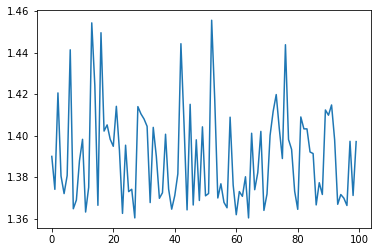

In [63]:
plt.figure()
plt.plot(np.arange(len(plotting_dict_train['loss'])), plotting_dict_train['loss'])